# Tweets about Covid-19 vaccines

In [1]:
# Import packages
import nltk
from pprint import pprint
import yaml
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import neattext as ntx
from wordcloud import WordCloud

## Part 1: EDA on during1_covidTweets

In [2]:
data = pd.read_csv('during2_covidTweets.csv')
data.head()

datetime             tweet_id  \
0  2022-03-30 21:33:13+00:00  1509282624954679296   
1  2022-03-30 21:32:54+00:00  1509282544872824832   
2  2022-03-30 21:32:49+00:00  1509282525918773252   
3  2022-03-30 21:32:24+00:00  1509282418510995456   
4  2022-03-30 21:32:12+00:00  1509282370163122176   

                                                text     username  \
0  How Japan Has Nearly Wiped Out Covid Infection...   nicktompan   
1  Our Microbiome Produces Metabolites that Inhib...   nicktompan   
2  God, Mental Health, Covid-19 &amp; Vaccination...   nicktompan   
3  Our Microbiome: An “Organ” to Thwart Covid-19 ...   nicktompan   
4  Biden aides to Congress: Fund COVID aid, don't...  AndyVermaut   

                                                 url  \
0  https://twitter.com/nicktompan/status/15092826...   
1  https://twitter.com/nicktompan/status/15092825...   
2  https://twitter.com/nicktompan/status/15092825...   
3  https://twitter.com/nicktompan/status/15092824...   
4  https://twitter.com/AndyVermaut/status/1509282...   

              user_location  like_count  retweet_count  follower_count  \
0  Virginia Beach, Virginia           0              0             144   
1  Virginia Beach, Virginia           0              0             144   
2  Virginia Beach, Virginia           0              0             144   
3  Virginia Beach, Virginia           0              0             144   
4         Diksmuide, België           0              0           31262   

   reply_count  verified                                         hashtags  
0            0     False                                              NaN  
1            0     False                                              NaN  
2            0     False                                              NaN  
3            0     False                                              NaN  
4            0     False  ['AndyVermautLovesAP', 'Whatsapp0032499357495']

In [3]:
data.shape

(58452, 12)

In [4]:
data.isnull().sum()

datetime              0
tweet_id              0
text                  0
username              0
url                   0
user_location      8915
like_count            0
retweet_count         0
follower_count        0
reply_count           0
verified              0
hashtags          51585
dtype: int64

### Simple visualisation (E.g Visualizing Tweet count vs Location)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'http://www.zyite.com/'),
  Text(1, 0, 'Diksmuide, België'),
  Text(2, 0, 'New Delhi, India'),
  Text(3, 0, 'Around the world'),
  Text(4, 0, 'Virginia Beach, Virginia'),
  Text(5, 0, 'New York, NY'),
  Text(6, 0, 'Washington, DC'),
  Text(7, 0, 'Philadelphia PA, USA'),
  Text(8, 0, 'California, USA'),
  Text(9, 0, 'New Zealand'),
  Text(10, 0, 'New York City'),
  Text(11, 0, 'El Segundo, CA'),
  Text(12, 0, 'USA'),
  Text(13, 0, 'Texas'),
  Text(14, 0, 'Saskatoon'),
  Text(15, 0, 'Israel'),
  Text(16, 0, 'Dublin City, Ireland'),
  Text(17, 0, 'Austin, Texas'),
  Text(18, 0, 'Englewood Cliffs, NJ'),
  Text(19, 0, 'San Francisco Bay Area')])

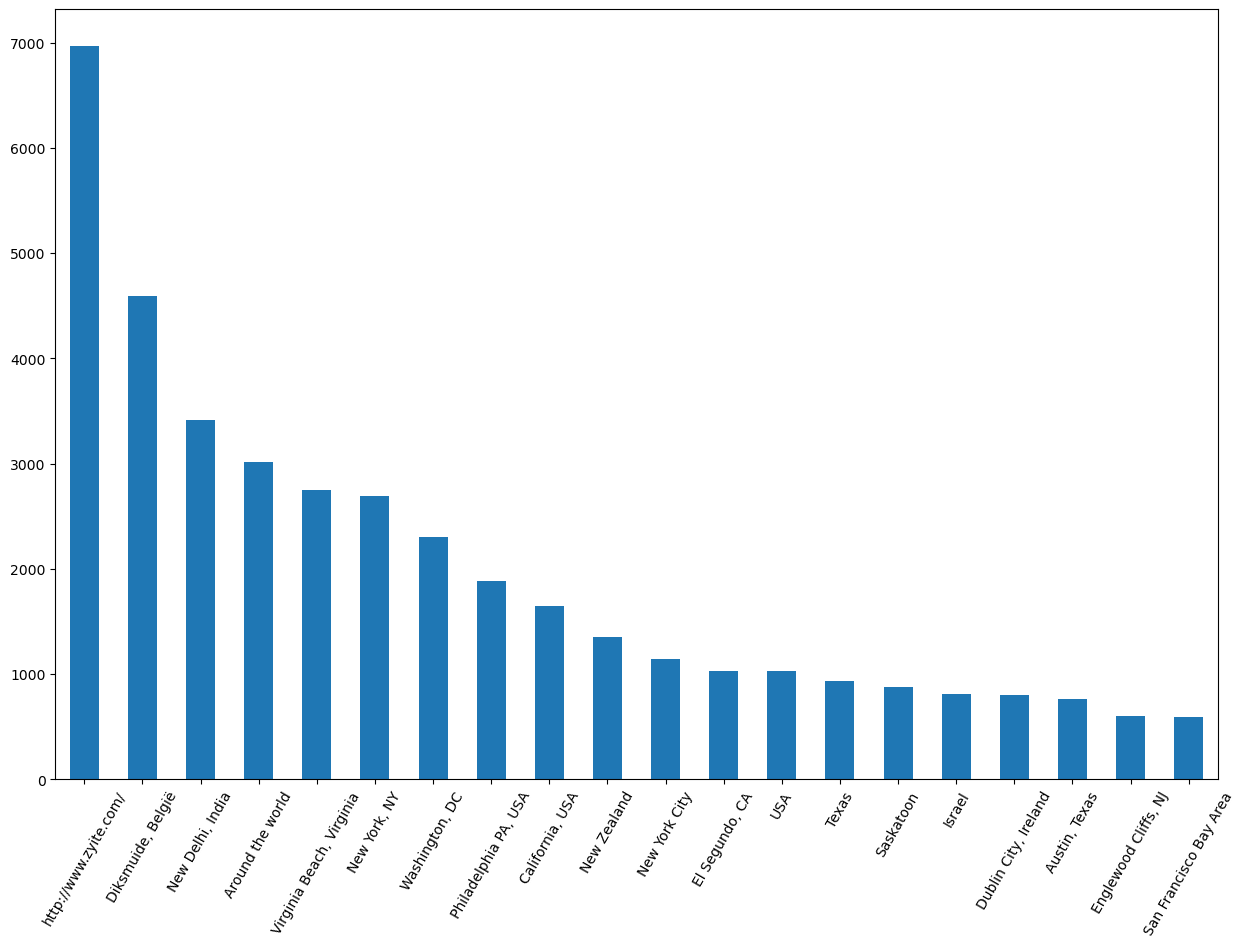

In [5]:
plt.figure(figsize=(15,10))
data['user_location'].value_counts().nlargest(20).plot(kind='bar')
plt.xticks(rotation=60)

### Word cloud in general (What do ppl talk about - Most frequent words or top keywords) 

(-0.5, 999.5, 499.5, -0.5)

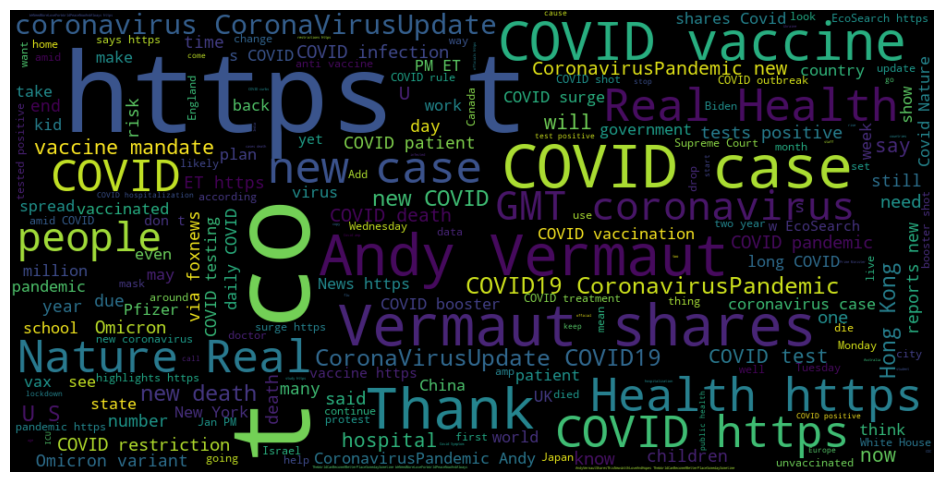

In [6]:
words = ' '.join([word for word in data['text']])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)

fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

### Check for duplicate tweets based on the tweet content

In [7]:
duplicate_tweets = data[data.duplicated(['text'])]
print('Number of duplicate tweets:', len(duplicate_tweets))

Number of duplicate tweets: 2370


### Drop duplicate tweets

In [8]:
data = data.drop_duplicates('text')
data.shape

(56082, 12)

### <font color=#FF0000>**Sentiment Analysis (using Textblob)**</font> <br>
**Polarity:** 1 means positive statement, -1 means a negative statement and 0 means neutral.
<br>
**Subjectivity:** Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is a float which lies in the range of [0,1].

### Clean the data using neattext library

In [9]:
data['clean_data'] = data['text'].apply(ntx.remove_hashtags)
data['clean_data'] = data['clean_data'].apply(ntx.remove_urls)
data['clean_data'] = data['clean_data'].apply(ntx.remove_userhandles)
data['clean_data'] = data['clean_data'].apply(ntx.remove_multiple_spaces)
data['clean_data'] = data['clean_data'].apply(ntx.remove_special_characters)

In [10]:
data['clean_data']

0        How Japan Has Nearly Wiped Out Covid Infection...
1        Our Microbiome Produces Metabolites that Inhib...
2        God Mental Health Covid19 amp Vaccinations  Na...
3        Our Microbiome An Organ to Thwart Covid19  Nat...
4        Biden aides to Congress Fund COVID aid dont cu...
                               ...                        
58447    CDC cruise travel warning raised to level 4 am...
58448    Ron DeSantis is MIA Critics Attack Florida Gov...
58449    NY COVID case count hits new record positivity...
58450    As surges US breaks COVID19 case records CBS N...
58451    COVID19 has killed more than 1000 of our neigh...
Name: clean_data, Length: 56082, dtype: object

In [11]:
data.shape

(56082, 13)

### Using stopwords to remove words that are generally considered to be of little value 

In [12]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [13]:
stop_words = stopwords.words('english')   
len(stop_words)

179

In [14]:
def stopWords(tweet):
    clean_tweet = tweet
    clean_tweet = " ".join(word for word in clean_tweet.split() if word not in stop_words)
    return clean_tweet

In [15]:
data['clean_data'] = data['clean_data'].apply(lambda x: stopWords(x))

In [16]:
data.head()

datetime             tweet_id  \
0  2022-03-30 21:33:13+00:00  1509282624954679296   
1  2022-03-30 21:32:54+00:00  1509282544872824832   
2  2022-03-30 21:32:49+00:00  1509282525918773252   
3  2022-03-30 21:32:24+00:00  1509282418510995456   
4  2022-03-30 21:32:12+00:00  1509282370163122176   

                                                text     username  \
0  How Japan Has Nearly Wiped Out Covid Infection...   nicktompan   
1  Our Microbiome Produces Metabolites that Inhib...   nicktompan   
2  God, Mental Health, Covid-19 &amp; Vaccination...   nicktompan   
3  Our Microbiome: An “Organ” to Thwart Covid-19 ...   nicktompan   
4  Biden aides to Congress: Fund COVID aid, don't...  AndyVermaut   

                                                 url  \
0  https://twitter.com/nicktompan/status/15092826...   
1  https://twitter.com/nicktompan/status/15092825...   
2  https://twitter.com/nicktompan/status/15092825...   
3  https://twitter.com/nicktompan/status/15092824...   
4  https://twitter.com/AndyVermaut/status/1509282...   

              user_location  like_count  retweet_count  follower_count  \
0  Virginia Beach, Virginia           0              0             144   
1  Virginia Beach, Virginia           0              0             144   
2  Virginia Beach, Virginia           0              0             144   
3  Virginia Beach, Virginia           0              0             144   
4         Diksmuide, België           0              0           31262   

   reply_count  verified                                         hashtags  \
0            0     False                                              NaN   
1            0     False                                              NaN   
2            0     False                                              NaN   
3            0     False                                              NaN   
4            0     False  ['AndyVermautLovesAP', 'Whatsapp0032499357495']   

                                          clean_data  
0  How Japan Has Nearly Wiped Out Covid Infection...  
1  Our Microbiome Produces Metabolites Inhibit Co...  
2  God Mental Health Covid19 amp Vaccinations Nat...  
3  Our Microbiome An Organ Thwart Covid19 Natures...  
4  Biden aides Congress Fund COVID aid dont cut b...

### Assigning Polarity and Subjectivity to the Tweets using Textblob

In [17]:
from textblob import TextBlob

# Function to assign polarity and subjectivity to the tweets
def blob_fun(text):
    senti = TextBlob(text)
    senti_polarity = senti.sentiment.polarity
    senti_subjectivity = senti.sentiment.subjectivity
    
    if senti_polarity > 0:
        res = 'Positive'
    elif senti_polarity < 0:
        res = 'Negative'
    elif senti_polarity == 0:
        res ="Neutral"
        
    result = {'polarity':senti_polarity,'subjectivity':senti_subjectivity,'sentiment':res}
    
    return result

In [18]:
data['results'] = data['clean_data'].apply(lambda x: blob_fun(x))

In [19]:
data.head()

datetime             tweet_id  \
0  2022-03-30 21:33:13+00:00  1509282624954679296   
1  2022-03-30 21:32:54+00:00  1509282544872824832   
2  2022-03-30 21:32:49+00:00  1509282525918773252   
3  2022-03-30 21:32:24+00:00  1509282418510995456   
4  2022-03-30 21:32:12+00:00  1509282370163122176   

                                                text     username  \
0  How Japan Has Nearly Wiped Out Covid Infection...   nicktompan   
1  Our Microbiome Produces Metabolites that Inhib...   nicktompan   
2  God, Mental Health, Covid-19 &amp; Vaccination...   nicktompan   
3  Our Microbiome: An “Organ” to Thwart Covid-19 ...   nicktompan   
4  Biden aides to Congress: Fund COVID aid, don't...  AndyVermaut   

                                                 url  \
0  https://twitter.com/nicktompan/status/15092826...   
1  https://twitter.com/nicktompan/status/15092825...   
2  https://twitter.com/nicktompan/status/15092825...   
3  https://twitter.com/nicktompan/status/15092824...   
4  https://twitter.com/AndyVermaut/status/1509282...   

              user_location  like_count  retweet_count  follower_count  \
0  Virginia Beach, Virginia           0              0             144   
1  Virginia Beach, Virginia           0              0             144   
2  Virginia Beach, Virginia           0              0             144   
3  Virginia Beach, Virginia           0              0             144   
4         Diksmuide, België           0              0           31262   

   reply_count  verified                                         hashtags  \
0            0     False                                              NaN   
1            0     False                                              NaN   
2            0     False                                              NaN   
3            0     False                                              NaN   
4            0     False  ['AndyVermautLovesAP', 'Whatsapp0032499357495']   

                                          clean_data  \
0  How Japan Has Nearly Wiped Out Covid Infection...   
1  Our Microbiome Produces Metabolites Inhibit Co...   
2  God Mental Health Covid19 amp Vaccinations Nat...   
3  Our Microbiome An Organ Thwart Covid19 Natures...   
4  Biden aides Congress Fund COVID aid dont cut b...   

                                             results  
0  {'polarity': 0.15000000000000002, 'subjectivit...  
1  {'polarity': 0.2, 'subjectivity': 0.3000000000...  
2  {'polarity': 0.05, 'subjectivity': 0.25, 'sent...  
3  {'polarity': 0.2, 'subjectivity': 0.3000000000...  
4  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...

In [20]:
data.shape

(56082, 14)

In [21]:
data = data.join(pd.json_normalize(data = data['results']))

In [22]:
data.head()

datetime             tweet_id  \
0  2022-03-30 21:33:13+00:00  1509282624954679296   
1  2022-03-30 21:32:54+00:00  1509282544872824832   
2  2022-03-30 21:32:49+00:00  1509282525918773252   
3  2022-03-30 21:32:24+00:00  1509282418510995456   
4  2022-03-30 21:32:12+00:00  1509282370163122176   

                                                text     username  \
0  How Japan Has Nearly Wiped Out Covid Infection...   nicktompan   
1  Our Microbiome Produces Metabolites that Inhib...   nicktompan   
2  God, Mental Health, Covid-19 &amp; Vaccination...   nicktompan   
3  Our Microbiome: An “Organ” to Thwart Covid-19 ...   nicktompan   
4  Biden aides to Congress: Fund COVID aid, don't...  AndyVermaut   

                                                 url  \
0  https://twitter.com/nicktompan/status/15092826...   
1  https://twitter.com/nicktompan/status/15092825...   
2  https://twitter.com/nicktompan/status/15092825...   
3  https://twitter.com/nicktompan/status/15092824...   
4  https://twitter.com/AndyVermaut/status/1509282...   

              user_location  like_count  retweet_count  follower_count  \
0  Virginia Beach, Virginia           0              0             144   
1  Virginia Beach, Virginia           0              0             144   
2  Virginia Beach, Virginia           0              0             144   
3  Virginia Beach, Virginia           0              0             144   
4         Diksmuide, België           0              0           31262   

   reply_count  verified                                         hashtags  \
0            0     False                                              NaN   
1            0     False                                              NaN   
2            0     False                                              NaN   
3            0     False                                              NaN   
4            0     False  ['AndyVermautLovesAP', 'Whatsapp0032499357495']   

                                          clean_data  \
0  How Japan Has Nearly Wiped Out Covid Infection...   
1  Our Microbiome Produces Metabolites Inhibit Co...   
2  God Mental Health Covid19 amp Vaccinations Nat...   
3  Our Microbiome An Organ Thwart Covid19 Natures...   
4  Biden aides Congress Fund COVID aid dont cut b...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.15000000000000002, 'subjectivit...      0.15          0.35   
1  {'polarity': 0.2, 'subjectivity': 0.3000000000...      0.20          0.30   
2  {'polarity': 0.05, 'subjectivity': 0.25, 'sent...      0.05          0.25   
3  {'polarity': 0.2, 'subjectivity': 0.3000000000...      0.20          0.30   
4  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...      0.00          0.00   

  sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4   Neutral

In [23]:
data.rename(columns={'sentiment': 'Textblob'}, inplace=True)

In [24]:
data.head()

datetime             tweet_id  \
0  2022-03-30 21:33:13+00:00  1509282624954679296   
1  2022-03-30 21:32:54+00:00  1509282544872824832   
2  2022-03-30 21:32:49+00:00  1509282525918773252   
3  2022-03-30 21:32:24+00:00  1509282418510995456   
4  2022-03-30 21:32:12+00:00  1509282370163122176   

                                                text     username  \
0  How Japan Has Nearly Wiped Out Covid Infection...   nicktompan   
1  Our Microbiome Produces Metabolites that Inhib...   nicktompan   
2  God, Mental Health, Covid-19 &amp; Vaccination...   nicktompan   
3  Our Microbiome: An “Organ” to Thwart Covid-19 ...   nicktompan   
4  Biden aides to Congress: Fund COVID aid, don't...  AndyVermaut   

                                                 url  \
0  https://twitter.com/nicktompan/status/15092826...   
1  https://twitter.com/nicktompan/status/15092825...   
2  https://twitter.com/nicktompan/status/15092825...   
3  https://twitter.com/nicktompan/status/15092824...   
4  https://twitter.com/AndyVermaut/status/1509282...   

              user_location  like_count  retweet_count  follower_count  \
0  Virginia Beach, Virginia           0              0             144   
1  Virginia Beach, Virginia           0              0             144   
2  Virginia Beach, Virginia           0              0             144   
3  Virginia Beach, Virginia           0              0             144   
4         Diksmuide, België           0              0           31262   

   reply_count  verified                                         hashtags  \
0            0     False                                              NaN   
1            0     False                                              NaN   
2            0     False                                              NaN   
3            0     False                                              NaN   
4            0     False  ['AndyVermautLovesAP', 'Whatsapp0032499357495']   

                                          clean_data  \
0  How Japan Has Nearly Wiped Out Covid Infection...   
1  Our Microbiome Produces Metabolites Inhibit Co...   
2  God Mental Health Covid19 amp Vaccinations Nat...   
3  Our Microbiome An Organ Thwart Covid19 Natures...   
4  Biden aides Congress Fund COVID aid dont cut b...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.15000000000000002, 'subjectivit...      0.15          0.35   
1  {'polarity': 0.2, 'subjectivity': 0.3000000000...      0.20          0.30   
2  {'polarity': 0.05, 'subjectivity': 0.25, 'sent...      0.05          0.25   
3  {'polarity': 0.2, 'subjectivity': 0.3000000000...      0.20          0.30   
4  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...      0.00          0.00   

   Textblob  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4   Neutral

### Visualize Positive, Negative & Neutral sentiments (wordcloud, bar chart & sentiments of positive, negative, and neutral based on different countries.

In [25]:
# categorized tweets in seperate Series
positive_tweet =  data[data['Textblob'] == 'Positive']['clean_data']
negative_tweet =  data[data['Textblob'] == 'Negative']['clean_data']
neutral_tweet = data[data['Textblob'] == 'Neutral']['clean_data']

In [26]:
def percent(x,y):
    return print("Percentage of "+ y +" tweets :",round(len(x)/data.shape[0]*100,3),"%")

In [27]:
percent(positive_tweet, 'positive')
percent(negative_tweet, 'negative')
percent(neutral_tweet, 'neutral')

Percentage of positive tweets : 39.626 %
Percentage of negative tweets : 15.59 %
Percentage of neutral tweets : 40.583 %


In [28]:
# Function for creating WordClouds
def cloud_of_Words(tweets,title):
    forcloud = ' '.join([tweet for tweet in tweets])
    wordcloud = WordCloud(width =500,height = 300,random_state =5,max_font_size=110).generate(forcloud)
    plt.imshow(wordcloud, interpolation ='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.figure(figsize = (10,8))

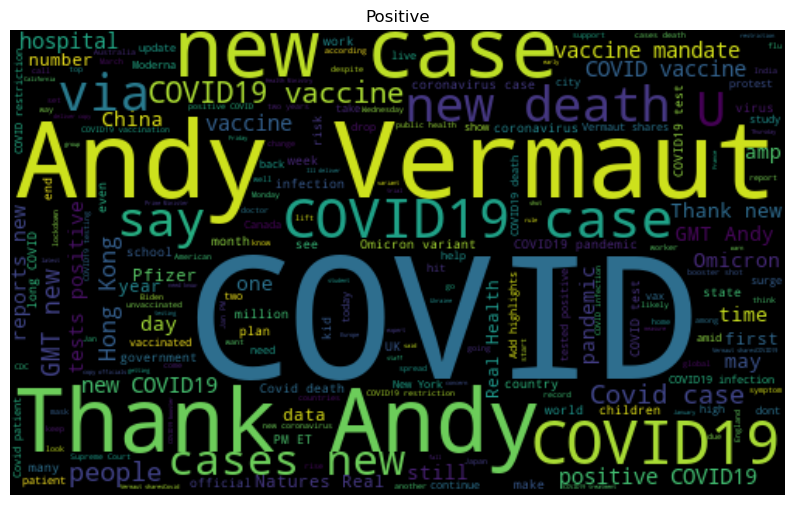

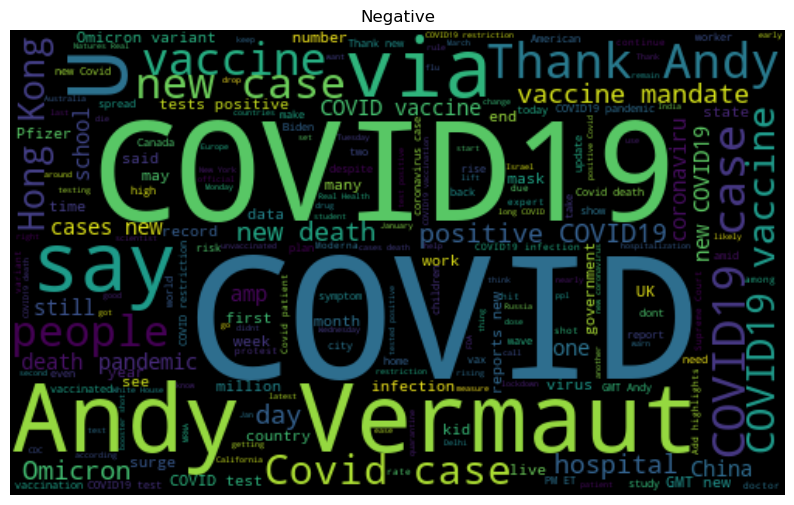

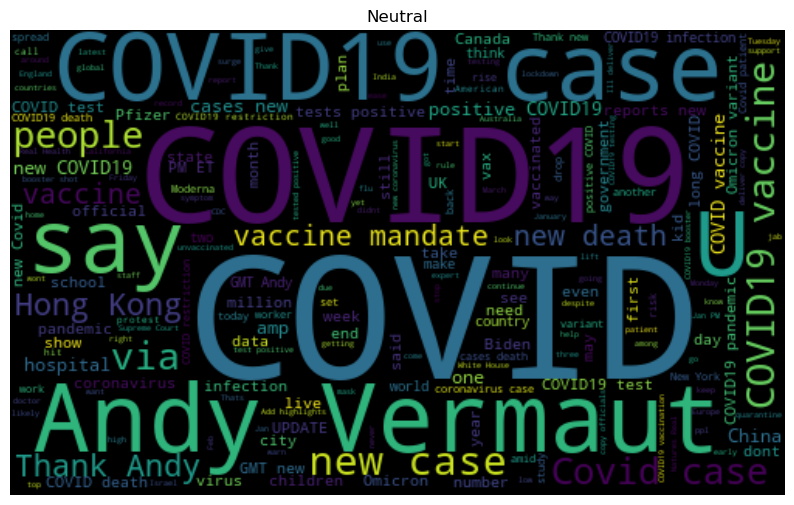

<Figure size 1000x800 with 0 Axes>

In [29]:
plt.figure(figsize = (10,8))
# Creating wordclouds for positive, negative, neutral tweets
cloud_of_Words(positive_tweet, 'Positive')
cloud_of_Words(negative_tweet, 'Negative')
cloud_of_Words(neutral_tweet, 'Neutral')

22223
22760
8743


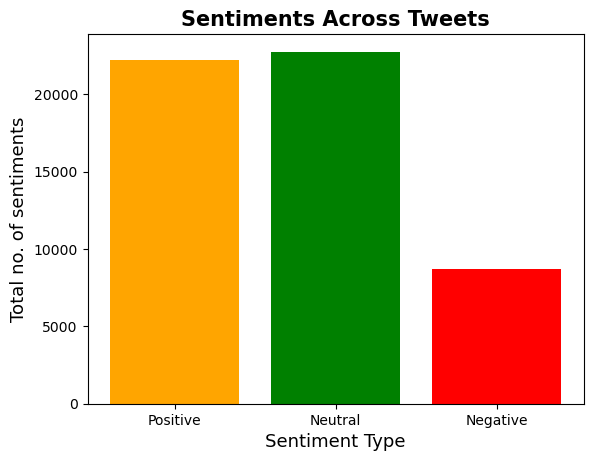

In [30]:
plt.title('Sentiments Across Tweets',fontsize = 15, fontweight = 'bold')

pos_total = data[data['Textblob'] == 'Positive']['Textblob'].count()
neu_total = data[data['Textblob'] == 'Neutral']['Textblob'].count()
neg_total = data[data['Textblob'] == 'Negative']['Textblob'].count()
print(pos_total)
print(neu_total)
print(neg_total)

sentiment_type = ['Positive','Neutral','Negative']
sentiment_total = [pos_total, neu_total, neg_total]

plt.bar(sentiment_type, sentiment_total, color = ['orange', 'green', 'red'])
plt.ylabel('Total no. of sentiments',fontsize=13)
plt.xlabel('Sentiment Type',fontsize=13)
plt.show()

### <font color=#FF0000>**Sentiment Analysis (Using Sentiment Intensity Analyzer)**</font> <br>

A class in the nltk (Natural Language Toolkit) library of Python that is used for sentiment analysis of text data. Specifically, it is a rule-based sentiment analysis tool that uses a lexicon of words and their associated sentiment scores to compute the overall sentiment of a piece of text.

The SentimentIntensityAnalyzer() class has a polarity_scores() method that takes a string of text as input and returns a dictionary containing the sentiment scores for that text. 

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [32]:
sid = SentimentIntensityAnalyzer()
ps = lambda x : sid.polarity_scores(x)
sentiment_scores = data.text.apply(ps)
sentiment_scores

0        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1        {'neg': 0.178, 'neu': 0.822, 'pos': 0.0, 'comp...
2        {'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'comp...
3        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4        {'neg': 0.0, 'neu': 0.908, 'pos': 0.092, 'comp...
                               ...                        
58447    {'neg': 0.118, 'neu': 0.882, 'pos': 0.0, 'comp...
58448    {'neg': 0.29, 'neu': 0.71, 'pos': 0.0, 'compou...
58449    {'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'comp...
58450    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
58451    {'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound...
Name: text, Length: 56082, dtype: object

In [33]:
sentiment_df = pd.DataFrame(data = list(sentiment_scores))
sentiment_df.head()

neg    neu    pos  compound
0  0.000  1.000  0.000    0.0000
1  0.178  0.822  0.000   -0.3818
2  0.000  0.811  0.189    0.2732
3  0.000  1.000  0.000    0.0000
4  0.000  0.908  0.092    0.2057

We can see that there is neg for negative sentiment, neu for neutral sentiment, pos for positive sentiment, and compound as the average rate of the sentiment. We will focused on the compound.

For negative sentiment, the compound score will be closer to -1, and the opposite goes for the positive sentiment, which will be closer to 1. Neutral sentiment will be a 0.

For our analysis, we will create another column called label, where we will be labelling the scores based on the compound polarity value

In [34]:
labelize = lambda x : 'neutral' if x==0 else('positive' if x>0 else 'negative')
sentiment_df['Vader'] = sentiment_df.compound.apply(labelize)
sentiment_df.head()

neg    neu    pos  compound     Vader
0  0.000  1.000  0.000    0.0000   neutral
1  0.178  0.822  0.000   -0.3818  negative
2  0.000  0.811  0.189    0.2732  positive
3  0.000  1.000  0.000    0.0000   neutral
4  0.000  0.908  0.092    0.2057  positive

In [35]:
filtered_label = data.join(sentiment_df.Vader)
filtered_label.head()

datetime             tweet_id  \
0  2022-03-30 21:33:13+00:00  1509282624954679296   
1  2022-03-30 21:32:54+00:00  1509282544872824832   
2  2022-03-30 21:32:49+00:00  1509282525918773252   
3  2022-03-30 21:32:24+00:00  1509282418510995456   
4  2022-03-30 21:32:12+00:00  1509282370163122176   

                                                text     username  \
0  How Japan Has Nearly Wiped Out Covid Infection...   nicktompan   
1  Our Microbiome Produces Metabolites that Inhib...   nicktompan   
2  God, Mental Health, Covid-19 &amp; Vaccination...   nicktompan   
3  Our Microbiome: An “Organ” to Thwart Covid-19 ...   nicktompan   
4  Biden aides to Congress: Fund COVID aid, don't...  AndyVermaut   

                                                 url  \
0  https://twitter.com/nicktompan/status/15092826...   
1  https://twitter.com/nicktompan/status/15092825...   
2  https://twitter.com/nicktompan/status/15092825...   
3  https://twitter.com/nicktompan/status/15092824...   
4  https://twitter.com/AndyVermaut/status/1509282...   

              user_location  like_count  retweet_count  follower_count  \
0  Virginia Beach, Virginia           0              0             144   
1  Virginia Beach, Virginia           0              0             144   
2  Virginia Beach, Virginia           0              0             144   
3  Virginia Beach, Virginia           0              0             144   
4         Diksmuide, België           0              0           31262   

   reply_count  verified                                         hashtags  \
0            0     False                                              NaN   
1            0     False                                              NaN   
2            0     False                                              NaN   
3            0     False                                              NaN   
4            0     False  ['AndyVermautLovesAP', 'Whatsapp0032499357495']   

                                          clean_data  \
0  How Japan Has Nearly Wiped Out Covid Infection...   
1  Our Microbiome Produces Metabolites Inhibit Co...   
2  God Mental Health Covid19 amp Vaccinations Nat...   
3  Our Microbiome An Organ Thwart Covid19 Natures...   
4  Biden aides Congress Fund COVID aid dont cut b...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.15000000000000002, 'subjectivit...      0.15          0.35   
1  {'polarity': 0.2, 'subjectivity': 0.3000000000...      0.20          0.30   
2  {'polarity': 0.05, 'subjectivity': 0.25, 'sent...      0.05          0.25   
3  {'polarity': 0.2, 'subjectivity': 0.3000000000...      0.20          0.30   
4  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...      0.00          0.00   

   Textblob     Vader  
0  Positive   neutral  
1  Positive  negative  
2  Positive  positive  
3  Positive   neutral  
4   Neutral  positive

In [36]:
counts_label = pd.DataFrame(filtered_label.Vader.value_counts().reset_index())
counts_label

index  Vader
0   neutral  18733
1  positive  17647
2  negative  17346

<AxesSubplot:xlabel='index', ylabel='Vader'>

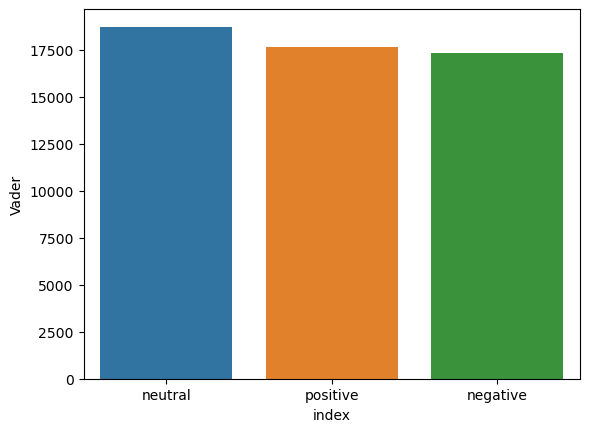

In [37]:
import seaborn as sns
sns.barplot(data=counts_label, x='index', y='Vader')

In [38]:
filtered_label['datetime'] = pd.to_datetime(filtered_label.datetime).dt.date
filtered_label['datetime']

0        2022-03-30
1        2022-03-30
2        2022-03-30
3        2022-03-30
4        2022-03-30
            ...    
58447    2022-01-01
58448    2022-01-01
58449    2022-01-01
58450    2022-01-01
58451    2022-01-01
Name: datetime, Length: 56082, dtype: object

In [39]:
filtered_label.head()

datetime             tweet_id  \
0  2022-03-30  1509282624954679296   
1  2022-03-30  1509282544872824832   
2  2022-03-30  1509282525918773252   
3  2022-03-30  1509282418510995456   
4  2022-03-30  1509282370163122176   

                                                text     username  \
0  How Japan Has Nearly Wiped Out Covid Infection...   nicktompan   
1  Our Microbiome Produces Metabolites that Inhib...   nicktompan   
2  God, Mental Health, Covid-19 &amp; Vaccination...   nicktompan   
3  Our Microbiome: An “Organ” to Thwart Covid-19 ...   nicktompan   
4  Biden aides to Congress: Fund COVID aid, don't...  AndyVermaut   

                                                 url  \
0  https://twitter.com/nicktompan/status/15092826...   
1  https://twitter.com/nicktompan/status/15092825...   
2  https://twitter.com/nicktompan/status/15092825...   
3  https://twitter.com/nicktompan/status/15092824...   
4  https://twitter.com/AndyVermaut/status/1509282...   

              user_location  like_count  retweet_count  follower_count  \
0  Virginia Beach, Virginia           0              0             144   
1  Virginia Beach, Virginia           0              0             144   
2  Virginia Beach, Virginia           0              0             144   
3  Virginia Beach, Virginia           0              0             144   
4         Diksmuide, België           0              0           31262   

   reply_count  verified                                         hashtags  \
0            0     False                                              NaN   
1            0     False                                              NaN   
2            0     False                                              NaN   
3            0     False                                              NaN   
4            0     False  ['AndyVermautLovesAP', 'Whatsapp0032499357495']   

                                          clean_data  \
0  How Japan Has Nearly Wiped Out Covid Infection...   
1  Our Microbiome Produces Metabolites Inhibit Co...   
2  God Mental Health Covid19 amp Vaccinations Nat...   
3  Our Microbiome An Organ Thwart Covid19 Natures...   
4  Biden aides Congress Fund COVID aid dont cut b...   

                                             results  polarity  subjectivity  \
0  {'polarity': 0.15000000000000002, 'subjectivit...      0.15          0.35   
1  {'polarity': 0.2, 'subjectivity': 0.3000000000...      0.20          0.30   
2  {'polarity': 0.05, 'subjectivity': 0.25, 'sent...      0.05          0.25   
3  {'polarity': 0.2, 'subjectivity': 0.3000000000...      0.20          0.30   
4  {'polarity': 0.0, 'subjectivity': 0.0, 'sentim...      0.00          0.00   

   Textblob     Vader  
0  Positive   neutral  
1  Positive  negative  
2  Positive  positive  
3  Positive   neutral  
4   Neutral  positive

In [40]:
data_vader = filtered_label[['username', 'datetime', 'Vader']].groupby(['datetime', 'Vader']).count().reset_index()
data_vader.columns = ['date', 'Vader', 'counts']
data_vader.head()

date     Vader  counts
0  2022-01-01  negative     159
1  2022-01-01   neutral     188
2  2022-01-01  positive     155
3  2022-01-02  negative     237
4  2022-01-02   neutral     210

In [41]:
px.line(data_vader, x='date', y='counts', color='Vader', title='COVID-19 Vaccines Sentiment Analysis (Vader)')

In [42]:
data_Textblob = filtered_label[['username', 'datetime', 'Textblob']].groupby(['datetime', 'Textblob']).count().reset_index()
data_Textblob.columns = ['date', 'Textblob', 'counts']
data_Textblob.head()

date  Textblob  counts
0  2022-01-01  Negative      90
1  2022-01-01   Neutral     221
2  2022-01-01  Positive     191
3  2022-01-02  Negative     125
4  2022-01-02   Neutral     263

In [43]:
px.line(data_Textblob, x='date', y='counts', color='Textblob', title='COVID-19 Vaccines Sentiment Analysis (Textblob)')

## Conclusion